In [ ]:
import os 
import sys
import numpy as np
from selenium import webdriver
import glob
import itertools
import urllib
import time
import cv2
from random import shuffle
import ffmpy
import matplotlib.pyplot as plt
import keras
import imp
import label_data
import imp
import pandas as pd
imp.reload(label_data)
%matplotlib inline

#### Convert movies to avi

In [54]:
movies = glob.glob('/Users/alexandreattia/Music/iTunes/iTunes Music/TV Shows/Les Simpson/*.mp4') + \
glob.glob('/Users/alexandreattia/Music/iTunes/iTunes Music/TV Shows/Les Simpson/*.m4v')
top_k = 10
for p in range(top_k):
    print('\r%i/%i' % (p,top_k), end='')
    ff = ffmpy.FFmpeg(
        inputs={np.random.choice(movies): None},
        outputs={'./video%d.avi'%p: None})
    ff.run()

9/10

In [174]:
movies = glob.glob('/Users/alexandreattia/Music/iTunes/iTunes Music/TV Shows/Les Simpson/*.mp4')
top_k = 1
movies = [k for k in movies if 'un ennemi tr' in k.lower()]
for i, p in enumerate(movies[:top_k]):
    ff = ffmpy.FFmpeg(
        inputs={p: None},
        outputs={'./video_target_%s.avi' % i: None})
    ff.run()

#### Download pictures

In [77]:
for character in characters:
    char = character.split('/')[2]
    browser = webdriver.Chrome()
    browser.set_page_load_timeout(10)
    time.sleep(np.random.randint(5, 13)*0.1)
    for p in range(5):
        link = "https://search.aol.com/aol/image?q=%s+%s&s_it=searchtabs&v_t=na&page=%d" % ('simpson', char.replace('_','+'), p+1)
        try:
            browser.get(link)
        except:
            time.sleep(np.random.randint(7)*0.1)
        images = browser.find_elements_by_tag_name('img')
        for i, image in enumerate(images):
            src = image.get_attribute("src")
            if src:
                path, _ = urllib.request.urlretrieve(src)
                os.rename(path, './characters/%s/aol_%d_%s.png' % (char,p,i))
        time.sleep(np.random.randint(10)*0.1)
    browser.quit()

In [ ]:
char = 'kent brockman'
link = "https://images.search.yahoo.com/search/images;_ylt=AwrTcYSZtSVZ\
boAA7FuJzbkF;_ylu=X3oDMTBsZ29xY3ZzBHNlYwNzZWFyY2gEc2xrA2J1dHRvbg--;_ylc=X1MDOTYwNjI4NTcEX\
3IDMgRhY3RuA2NsawRiY2sDZWltbXRkdGFpcHQ0aCUyNmIlM0Q0JTI2ZCUzREJVYVpCTE5wWUVLSUIxbWNQSzRYNEdYZTF\
5NC0lMjZzJTNEOTglMjZpJTNEbG93NXlrSzFTUXdtTEhLby5Md2EEY3NyY3B2aWQDUno0T0tUSXdOaTdwV3QxdlZTejBrUWU3Tnp\
NdU53QUFBQUNtT00yVgRmcgNzZnAEZnIyA3NhLWdwBGdwcmlkA3lnQ05QTnlSU2dxRTVvRl8zOWt4NkEEbXRlc3RpZANudWxsBG5fc3VnZwMxBG9yaWdpb\
gNpbWFnZXMuc2VhcmNoLnlhaG9vLmNvbQRwb3MDMARwcXN0cgMEcHFzdHJsAwRxc3RybAMyMwRxdWVyeQNhYnJhaGFtIGdyYW5kcGEgc2ltcHNvbgR0X3N0\
bXADMTQ5NTY0MzgwNQR2dGVzdGlkA251bGw-?gprid=ygCNPNyRSgqE5oF_39kx6A&pvid=Rz4OKTIwNi7pWt1vVSz0kQe7NzMuNwAAAACmO\
M2V&p={}&fr=sfp&fr2=sb-top-images.search.yahoo.com&ei=UTF-8&n=60&x=wrt".format(char.replace('_','+') + 'simpson')

#link='http://www.simpsoncrazy.com/pictures/bart'

browser = webdriver.Chrome()
browser.set_page_load_timeout(10)
try:
    browser.get(link)
except:
    time.sleep(np.random.randint(7)*0.1)
time.sleep(7)
images = browser.find_elements_by_tag_name('img')
for i, image in enumerate(images):
    src = image.get_attribute("src")
    if src:
        path, _ = urllib.request.urlretrieve(src)
        os.rename(path, './characters/%s/yahoo_%d_%s.jpg' % (char,np.random.randint(20), i))
for elem in glob.glob('./characters/%s/*.png'):
    k = cv2.imread(elem)
    if not k:
        os.remove(elem)
browser.quit()

#### Counting

In [53]:
characters = glob.glob('./characters/*')
d = []
dd = []
for character in characters:
    a = len([k for k in glob.glob(character + '/*') if 'edited' in k])
    b = len([k for k in glob.glob(character + '/*') if 'pic_video' in k])
    c = len([k for k in glob.glob(character + '/*') if 'pic_video' not in k and 'edited' not in k])
    dd.append({'name' : character.split('/')[2].replace('_',' ').title(),
               'edited' :a,
               'labeled':b,
               'total':a+b,
               'non-filtered':c,
               'train': round((a+b)*0.85),
               'test': round((a+b)*0.15)})
df = pd.DataFrame(dd)[['name', 'non-filtered',
                       'edited', 'labeled','total',
                      'train', 'test']].sort_values('total', ascending=False).reset_index(drop=True)
df['true_total'] = df.total
df.ix[df.total > (1000 / 0.85), 'true_total'] = int((1000 / 0.85))
top_k = 20
df2 =  pd.concat([df,pd.DataFrame({'name' : "TOTAL",
           'edited' :df[:top_k].edited.sum(),
           'labeled':df[:top_k].labeled.sum(),
           'total':df[:top_k].total.sum(),
           'non-filtered':df[:top_k]['non-filtered'].sum(),
           'train': df[:top_k].train.sum(),
           'test': df[:top_k].test.sum(),
           'true_total': df[:top_k].true_total.sum()}, index=[top_k])])
df2 = df2.sort_values('total', ascending=False).sort_index().reset_index(drop=True)
df2[['name', 'non-filtered',
    'edited', 'labeled','total',
    'train', 'test', "true_total"]][:1+df2[df2.name == 'TOTAL'].index[0]]

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,name,non-filtered,edited,labeled,total,train,test,true_total
0,Homer Simpson,1,0,2233,2233,1898,335,1176
1,Ned Flanders,19,100,1348,1448,1231,217,1176
2,Moe Szyslak,73,232,1215,1447,1230,217,1176
3,Lisa Simpson,0,251,1142,1393,1184,209,1176
4,Bart Simpson,124,0,1327,1327,1128,199,1176
5,Marge Simpson,122,0,1291,1291,1097,194,1176
6,Krusty The Clown,0,281,935,1216,1034,182,1176
7,Principal Skinner,32,83,1121,1204,1023,181,1176
8,Charles Montgomery Burns,0,298,905,1203,1023,180,1176
9,Milhouse Van Houten,186,106,945,1051,893,158,1051


#### Filtering pictures 

In [8]:
characters = glob.glob('./characters/*')
d = []
for character in characters:
    a = len([k for k in glob.glob(character + '/*') if 'edited' in k])
    b = len([k for k in glob.glob(character + '/*') if 'pic_video' in k])
    d.append((character,a+b))
characters = [e[0] for e in sorted(d, key=lambda x:x[1], reverse=True)]

top_k = 10
characters = [e for e in characters if 'nelson' in e]
for character in characters:
    print(character.split('/')[2].replace('_',' ').upper())
    pictures =  [k for k in glob.glob(character + '/*') if 'edited' not in k and 'pic_vid' not in k]
    for pic in pictures:
        img = cv2.imread(pic)
        if img is not None:
            plt.imshow(img)
            plt.show()
            f = input('Keep the pictures, crop it or delete it ? [Y,C,N]')
            if f.lower() == 'skip':
                break
            if f.lower() in ['y', 'yes', '', 'keep', 'k']:
                title = pic.replace('.jpg', '%d_edited.jpg' % np.random.randint(500, 5000)).replace(
                            '.png', '%d_edited.jpg' % np.random.randint(500, 5000))
                cv2.imwrite(title, img)
                os.remove(pic)
            elif f.lower() in ['crop', 'c']:
                g = input('Right or Left half ? [R,L]')
                if g.lower() in ['right', 'r']:
                    img2 = img[:, int(img.shape[1]/2):]
                    plt.imshow(img2)
                    plt.show()
                    h = input('Good')
                    if h.lower() not in ['n', 'no']:
                        title = pic.replace('.jpg', '%d_edited.jpg' % np.random.randint(500, 5000)).replace(
                            '.png', '%d_edited.jpg' % np.random.randint(500, 5000))
                        cv2.imwrite(title, img2)
                        os.remove(pic)
                    else:
                        os.remove(pic)
                elif g.lower() in ['left', 'l']:
                    img2 = img[:, :int(img.shape[1]/2)]
                    plt.imshow(img2)
                    plt.show()
                    h = input('Good')
                    if h.lower() not in ['n', 'no']:
                        title = pic.replace('.jpg', '%d_edited.jpg' % np.random.randint(500, 5000)).replace(
                            '.png', '%d_edited.jpg' % np.random.randint(500, 5000))
                        cv2.imwrite(title, img2)
                        os.remove(pic)
                    else:
                        os.remove(pic)
            elif f.lower() in ['no','delete','d','n']:
                os.remove(pic)
        else:
            os.remove(pic)
        print('%d pictures edited' % len([k for k in glob.glob(character + '/*') if 'edited' in k]))

#### Data from videos

In [9]:
imp.reload(label_data)
label_data.labelized_data(to_shuffle=True)

#### Auto-creating set

In [43]:
for k in map_characters.values():
    if k not in [k.split('/')[2] for k in glob.glob('./autogenerate/*')]:
        os.mkdir('./autogenerate/%s/'% k)

In [48]:
imp.reload(label_data)
import train
imp.reload(train)
# map_characters = label_data.map_characters
# label_data.generate_pic_from_videos()
label_data.classify_pics()

1644/1644

In [7]:
for char in glob.glob('./autogenerate/*'):
    character = char.split('/')[2]
    pics = glob.glob(char+'/*')
    shuffle(pics)
    for pic in pics:
        img = cv2.imread(pic)
        plt.imshow(img)
        plt.show()
        corr = input('%s : Correct ? [Y/n] ' % character)
        if corr.lower() in ['y', 'yes']:
            os.rename(pic, './characters/%s/%s' % (character, pic.split('/')[3]))
        elif corr.lower() == 'skip':
            break
        else:
            os.remove(pic)

#### Clean Dataset

In [16]:
def mse(imageA, imageB):
    if imageA.shape[0] == imageB.shape[0] and imageA.shape[1] == imageB.shape[1]:
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err
    else:
        return imageA.shape[0]*imageA.shape[1]

In [31]:
pics = glob.glob('./characters/abraham_grampa_simpson/*.*')
pics = {pic.split('/')[3].replace('.jpg', '') : cv2.imread(pic) for pic in pics}

(416, 576, 3) (368, 496, 3)


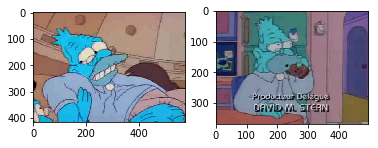

In [18]:
img1 = cv2.imread(pics[0])
img2 = cv2.imread(pics[1])
print(img1.shape, img2.shape)
f,ax = plt.subplots(ncols=2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [6]:
from label_data import map_characters
for char in map_characters.values():
    to_remove = []
    print(char)
    print(len(glob.glob('./characters/%s/*.*' % char)))
    pics = glob.glob('./characters/%s/*.*'% char)
    pics = {pic.split('/')[3]: cv2.imread(pic) for pic in pics}
    for a, b in itertools.combinations(pics.items(), 2):
        err = mse(a[1], b[1])
        if err == 0:
            to_remove.append('./characters/%s/' % char + b[0])
    for e in set(to_remove):
        try:
            os.remove(e)
        except:
            pass
    print(len(glob.glob('./characters/%s/*.*'% char)))

#### Create bounding box

In [2]:
with open('./annotation.txt') as f:
    already_labeled = [k.strip().split(',') for k in f.readlines()]
pics, x1, y1, x2, y2, char = zip(*already_labeled)

In [5]:
ind = np.random.choice(range(len(pics)), 3)
f, ax = plt.subplots(ncols=3, figsize=(10,5))
for k, i in enumerate(ind):
    img = cv2.imread(pics[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (int(x1[i]),int(y1[i])),(int(x2[i]),int(y2[i])),(0,255,0),3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, char[i].split('_')[0], (int(x1[i]),int(y1[i]) - 5), font, 0.7, (0,255,0), 1, cv2.LINE_AA)
    ax[k].imshow(img)

In [4]:
from shutil import copyfile
from tqdm import tqdm
for p in tqdm(pics):
    char = p.split('/')[8]
    pic_name = p.split('/')[::-1][0]
    copyfile('./characters/%s/%s' % (char, pic_name), './char_transfers/%s/%s' % (char, pic_name))

100%|██████████| 5324/5324 [00:05<00:00, 994.88it/s] 
